In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from heston import UnivariateHestonSV, MultivariateHestonSV
from heston import make_surface

In [2]:
data = pd.read_excel('data/equities.xlsx', index_col=0)
assets = data.corp.unique()
data.head()

,corp,strike,mat,iv,S0,adv,tot_shr,owned_shr,avg_buy_px,bs_px
0,Green Co.,30,0.083333,NaN,34,217000,30,4.25,31.5,NaN
1,Green Co.,30,0.250000,0.3747,34,217000,30,4.25,31.5,5.143945
2,Green Co.,30,0.500000,0.3686,34,217000,30,4.25,31.5,6.126322
3,Green Co.,35,0.083333,0.4211,34,217000,30,4.25,31.5,1.270197
4,Green Co.,35,0.250000,0.3418,34,217000,30,4.25,31.5,2.044304


In [3]:
mv_hes = MultivariateHestonSV(data.corp.unique())
fit_res = mv_hes.calibrate(
    data, px=[34,15,25], r=[0.045]*3,
    cov_s=np.array([
        [1, 0.3, 0.3],
        [0.3, 1, 0.3],
        [0.3, 0.3, 1]
    ])
)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6504e+00                                    2.35e+02    
       1              2         1.4146e-01      1.51e+00       2.11e-01       4.36e+00    
       2              3         4.5499e-02      9.60e-02       8.30e-01       5.98e-01    
       3              4         3.9557e-02      5.94e-03       9.50e-02       5.29e-02    
       4              5         3.9486e-02      7.07e-05       2.76e-01       2.26e+00    
       5              6         3.4344e-02      5.14e-03       5.67e-01       1.26e-01    
       6              7         3.3545e-02      7.99e-04       1.85e-01       1.29e+00    
       7              8         3.2516e-02      1.03e-03       2.47e-01       3.38e-01    
       8             10         3.2126e-02      3.91e-04       1.62e-01       3.60e-01    
       9             12         3.1825e-02      3.01e-04       1.37e-01       1.89e-01    

In [4]:
print(['kappa', 'v0', 'theta', 'eta', 'rho_sv'])
for res in fit_res:
    print(res.x)

['kappa', 'v0', 'theta', 'eta', 'rho_sv']
[36.63498442  0.38612228  0.10530884  2.52754124 -0.89758732]
[ 0.40361802  0.11266309  0.60890977  0.16575191 -0.89999301]
[ 2.04425538  0.14890609  0.30218984  0.40687692 -0.87634616]


In [5]:
def view_surface(func, asset, K, T):
    Ks, Ts, ivs = make_surface(
        iv_f[asset], K, T)

    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_wireframe(Ts, Ks, ivs, alpha=0.5)
    ax.scatter(Ts, Ks, ivs, color='black', alpha=0.3)

    mktiv_pivot = pd.pivot_table(
        data, values='iv', 
        index=['corp','strike'], columns=['mat'], aggfunc=np.mean)
    iv_table = mktiv_pivot.loc[asset,]
    K_mkt = np.array(iv_table.index)
    T_mkt = np.array(iv_table.columns)
    K_mkt, T_mkt = np.meshgrid(K_mkt, T_mkt)
    iv_mkt = iv_table.values

    ax.scatter(T_mkt, K_mkt, iv_mkt.T, color='red', alpha=1)
    ax.view_init(0, 20)

    ax = fig.add_subplot(122, projection='3d')
    ax.plot_wireframe(Ts, Ks, ivs, cmap=cm.coolwarm, alpha=0.5)
    ax.scatter(Ts, Ks, ivs, color='black', alpha=0.3)
    ax.scatter(T_mkt, K_mkt, iv_mkt.T, color='red', alpha=1)
    ax.view_init(30, 30)

/Users/zed/anaconda/lib/python3.6/site-packages/scipy/optimize/zeros.py:142: RuntimeWarning: derivative was zero.
  warnings.warn(msg, RuntimeWarning)


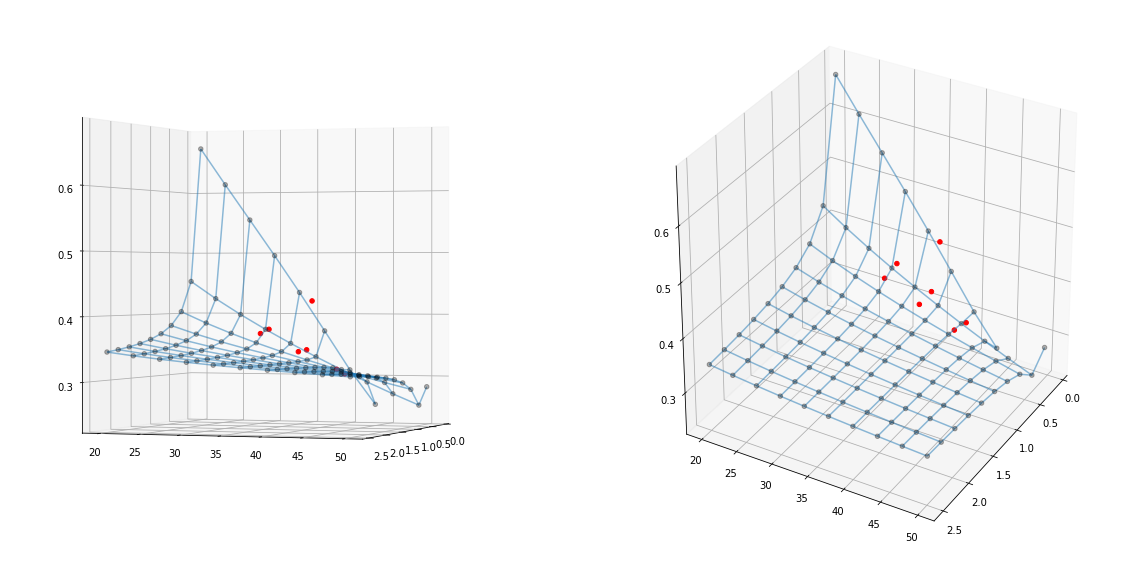

In [9]:
iv_f = mv_hes.make_iv_surface_functions(px=[34,15,25])
view_surface(
    iv_f[assets[0]], assets[0], 
    np.linspace(20, 50, 10), np.linspace(1/12, 2.5, 10))

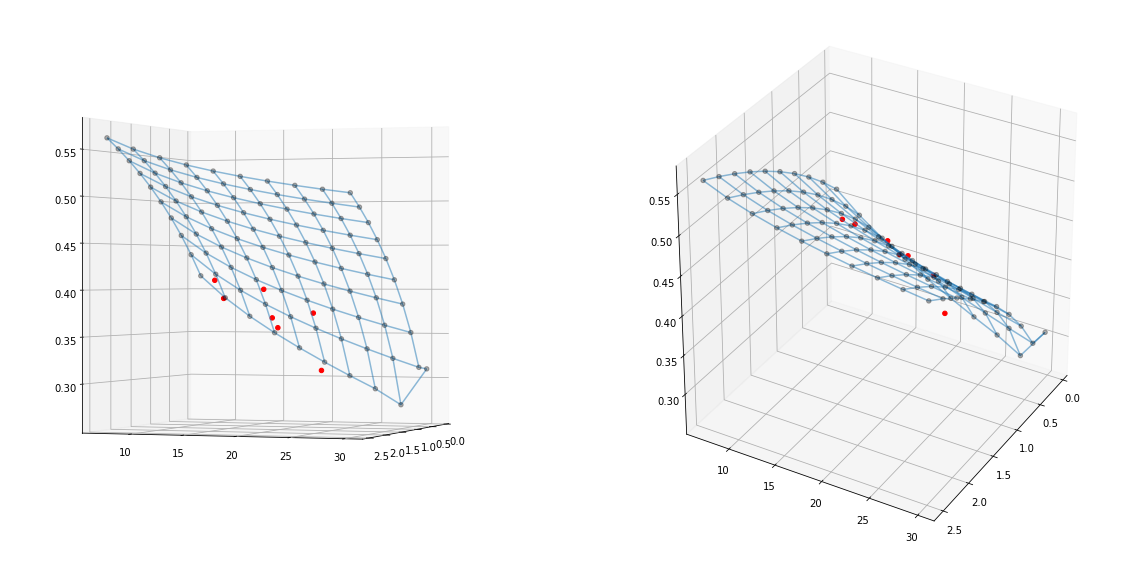

In [10]:
view_surface(
    iv_f[assets[1]], assets[1], 
    np.linspace(7, 30, 10), np.linspace(1/12, 2.5, 10))

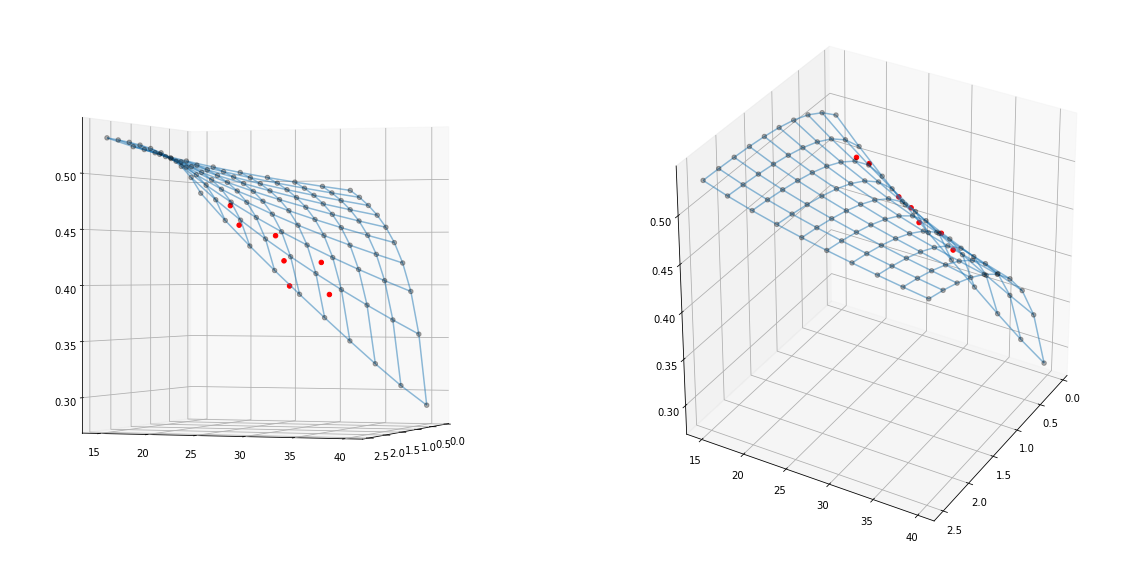

In [11]:
view_surface(
    iv_f[assets[2]], assets[2], 
    np.linspace(15, 40, 10), np.linspace(1/12, 2.5, 10))

In [5]:
from heston import Option, Call, Put, ZeroCostCollar

c = Call(mv_hes.univariates[assets[2]], 32.9, 2)
p = Put(mv_hes.univariates[assets[2]], 24, 2)
c2 = Call(mv_hes.univariates[assets[2]], 24, 2)
collar = p-c

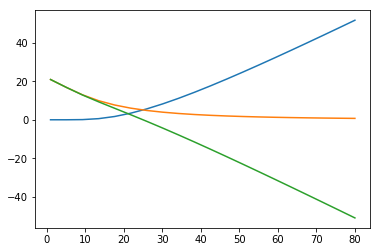

In [6]:
ss = np.linspace(1, 80 ,20)
plt.plot(ss, [c.price(s) for s in ss])
plt.plot(ss, [p.price(s) for s in ss])
plt.plot(ss, [collar.price(s) for s in ss])

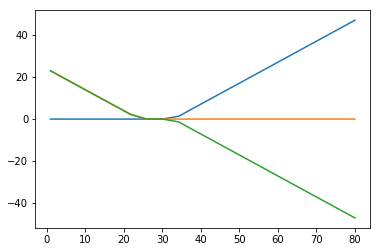

In [7]:
plt.plot(ss, [c.payoff(s) for s in ss])
plt.plot(ss, [p.payoff(s) for s in ss])
plt.plot(ss, [collar.payoff(s) for s in ss])

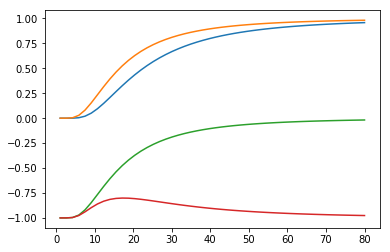

In [13]:
plt.plot(ss, [c.delta(s) for s in ss])
plt.plot(ss, [c2.delta(s) for s in ss])
plt.plot(ss, [p.delta(s) for s in ss])
plt.plot(ss, [collar.delta(s) for s in ss])

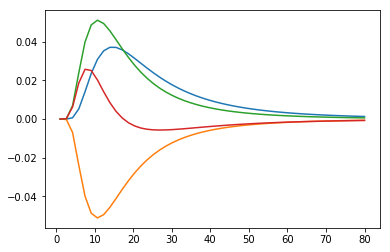

In [15]:
ss = np.linspace(1, 80 ,50)
plt.plot(ss, [c.gamma(s) for s in ss])
plt.plot(ss, [-c2.gamma(s) for s in ss])
plt.plot(ss, [p.gamma(s) for s in ss])
plt.plot(ss, [collar.gamma(s) for s in ss])

In [11]:
zcc1 = ZeroCostCollar(mv_hes.univariates[assets[2]], 25, put_K=24, T=2)
zcc2 = ZeroCostCollar(mv_hes.univariates[assets[2]], 25, put_K=20, T=2)
zcc3 = ZeroCostCollar(mv_hes.univariates[assets[2]], 25, put_K=18, T=2)

In [12]:
print(zcc1.put_K, zcc1.call_K)
print(zcc2.put_K, zcc2.call_K)
print(zcc3.put_K, zcc3.call_K)

24 32.89827156422527
20 40.87222718637944
18 45.62067498366222


100% (5 of 5) |###########################| Elapsed Time: 0:00:55 Time: 0:00:55


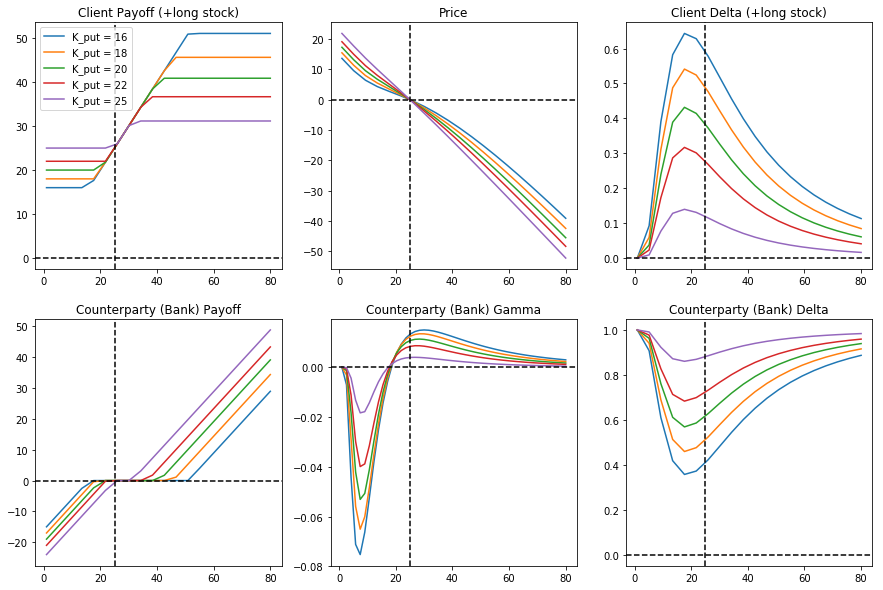

In [42]:
from progressbar import ProgressBar
fig, axes = plt.subplots(2,3,figsize=(15,10))
axes = axes.reshape(6,)
ss = np.linspace(1, 80 ,20)
bar = ProgressBar()
for k in bar([16, 18, 20, 22, 25]):
    ss = np.linspace(1, 80 ,20)
    zcc = ZeroCostCollar(mv_hes.univariates[assets[2]], 25, put_K=k, T=2)
    axes[0].plot(ss, [zcc.payoff(s)+s for s in ss], label=f'K_put = {k}')
    axes[3].plot(ss, [-zcc.payoff(s) for s in ss], label=f'K_put = {k}')
    axes[1].plot(ss, [zcc.price(s) for s in ss], label=f'K_put = {k}')
    axes[2].plot(ss, [zcc.delta(s)+1 for s in ss], label=f'K_put = {k}')
    axes[5].plot(ss, [-zcc.delta(s) for s in ss], label=f'K_put = {k}')
    
    ss = np.linspace(1, 80 ,50)
    axes[4].plot(ss, [-zcc.gamma(s) for s in ss])
    
axes[0].axvline(25, linestyle='--',color='black')
axes[0].axhline(0, linestyle='--',color='black')
axes[0].set_title('Client Payoff (+long stock)')
axes[0].legend()

axes[3].axvline(25, linestyle='--',color='black')
axes[3].axhline(0, linestyle='--',color='black')
axes[3].set_title('Counterparty (Bank) Payoff')

axes[1].axvline(25, linestyle='--',color='black')
axes[1].axhline(0, linestyle='--',color='black')
axes[1].set_title('Price')

axes[2].axvline(25, linestyle='--',color='black')
axes[2].axhline(0, linestyle='--',color='black')
axes[2].set_title('Client Delta (+long stock)')

axes[4].axvline(25, linestyle='--',color='black')
axes[4].axhline(0, linestyle='--',color='black')
axes[4].set_title('Counterparty (Bank) Gamma')

axes[5].axvline(25, linestyle='--',color='black')
axes[5].axhline(0, linestyle='--',color='black')
axes[5].set_title('Counterparty (Bank) Delta')

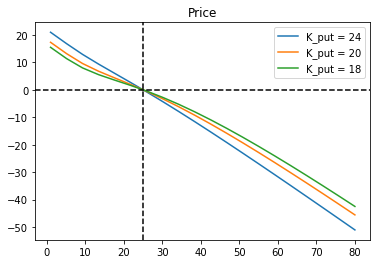

In [33]:
ss = np.linspace(1, 80 ,20)
plt.plot(ss, [zcc1.price(s) for s in ss], label='K_put = 24')
plt.plot(ss, [zcc2.price(s) for s in ss], label='K_put = 20')
plt.plot(ss, [zcc3.price(s) for s in ss], label='K_put = 18')
plt.axvline(25, linestyle='--',color='black')
plt.axhline(0, linestyle='--',color='black')
plt.title('Price')
plt.legend()

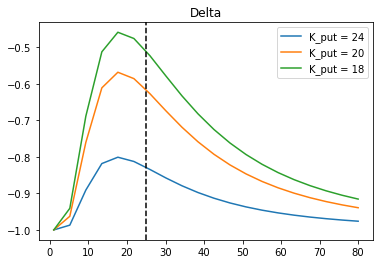

In [26]:
plt.plot(ss, [zcc1.delta(s) for s in ss], label='K_put = 24')
plt.plot(ss, [zcc2.delta(s) for s in ss], label='K_put = 20')
plt.plot(ss, [zcc3.delta(s) for s in ss], label='K_put = 18')
plt.axvline(25, linestyle='--',color='black')
plt.title('Delta')
plt.legend()

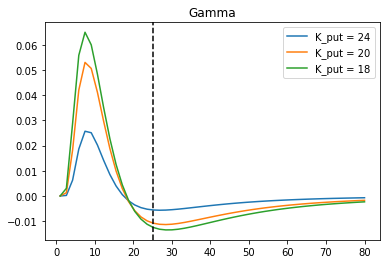

In [27]:
ss = np.linspace(1, 80 ,50)
plt.plot(ss, [zcc1.gamma(s) for s in ss], label='K_put = 24')
plt.plot(ss, [zcc2.gamma(s) for s in ss], label='K_put = 20')
plt.plot(ss, [zcc3.gamma(s) for s in ss], label='K_put = 18')
plt.axvline(25,linestyle='--',color='black')
plt.title('Gamma')
plt.legend()

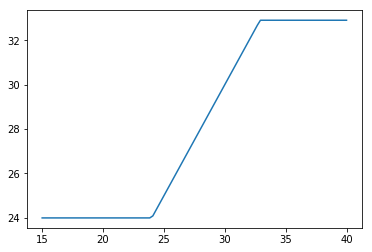

In [77]:
# 3, S0=25
call_p = price_f[assets[2]]
put_p = lambda S, K, T: call_p(S,K,T)+K*np.exp(-0.045*T)-S
s = np.linspace(15, 40 ,100)
c = (s-32.9).clip(0)
p = (24-s).clip(0)
plt.plot(s, p-c+s)

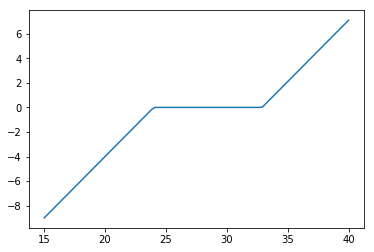

In [80]:
plt.plot(s, -p+c)

In [59]:
call_p(25, 29, 2),put_p(25, 24, 2)

(6.273183985824176, 5.094718659976522)

In [65]:
call_p(25, 32.9, 2),put_p(25, 24, 2)

(5.094246141866465, 5.094718659976522)

In [58]:
25*0.2

5.0